# Create AOI Image Tiles 

This notebook is used to create image tiles at DHS survaey locations for a given AOI (UTM Zone) using resampled and spatially aligned GeoTiff raster files that were previously created for the specific UTM zone using `prep_geospatial_data.ipynb`. The following processing steps are performed.

1. Define configurations (required input files, AOI parameters, file naming, etc.) 
2. Extract survey data from the Pakistan DHS shape file (specifically, Cluster IDs and GPS lat, lon)
3. Load AOI Raster Data
4. Convert each survey GPS location to the same UTM zone as the AOI image stack
5. Loop through all GPS locations (in UTM) and identify which points are within the AOI image stack
6. Crop image tiles from the AOI image stack:
    - For each GPS location (in UTM), find the nearest vertex in the image stack
    - Use that vertex point as the center of a bounding box for cropping an image tile from the stack for each data type (224 x 224)
    - Save each crop as a data sample with an associated file name that clearly identifies the data sample
    
<span style="color: red;"><b>IMPORTANT: This notebook should be executed once for each UTM zone for a given country</b></span>
    


## File System Structure

The top level file structure is shown below which includes five folders and three notebooks.

<pre style="font-family: monospace;">
<span style="color: blue;">./AOI</span>
<span style="color: blue;">./DHS</span>
<span style="color: gray;">./Nightlights</span>
<span style="color: gray;">./Population</span>
<span style="color: gray;">./Rainfall</span>

<span style="color: blue;">./prep_aoi_image_tiles.ipynb (this notebook)</span>
<span style="color: gray;">./prep_geospatial_data.ipynb</span>
<span style="color: gray;">./prep_rainfall_chirps.ipynb</span>
</pre>


## Input

The input GeoTiff files for this notebook come from this file structure (previoulsy generated by `prep_geospatial_data.ipynb`):

<pre style="font-family: monospace;">
./Nightlights/
    output/PK_42N/
        VNL_v22_npp-j01_2022_global_vcmslcfg_median_PK_42N_4_resampled_average.tif

./Population/
    output/PK_42N/
        landscan-global-2022_PK_42N_4_resampled_average.tif
            
./Rainfall/
    output/PK_42N/
        chirps-v2.0.2023_PK_42N_avg_PK_42N_4_resampled_average.tif      
</pre>

<span style="color: red;"><b>IMPORTANT: Each of these re-sampled GeoTiff files for the specified counrty and UTM zone should be copied to the corresponding `Image_Stack` folder as shown below.</b></span> This file structure below constitutes the "Image Stack" for the specified country and UTM zone. 

<pre style="font-family: monospace;">
./AOI/
    PK_42N/  
        Image_Stack/
            # Resampled, spatially aligned image stack.
            chirps-v2.0.2022_42N_avg_42N_2022_bilinear_4_resampled.tif
            landscan-global-2022_42N_2022_average_4_resampled.tif
            VNL_v22_npp-j01_2022_global_vcmslcfg_median_42N_2022_median_average_4_resampled.tif
            
</pre>

## Output

This notebook produces the following (parallel) file structure which contains image tiles for each of the DHS survey locations for each data type for the specificed country and UTM zone. Additionally, a Virtual Reference Table (VRT) file is produced for each datatype that references all the image tiles. These VRT files provide a convenient way to load the rastewr image tiles in QGIS for visual inspection.

<pre style="font-family: monospace;">
./AOI/
    PK_42N/  
        Image_Tiles/
            Nightlights/
                # Cropped image tiles at each DHS cluster location.
                PK_42N_001_C-002_Nightlights_2022_400m.tif
                PK_42N_002_C-003_Nightlights_2022_400m.tif
                    :
                PK_42N_265_C-415_Nightlights_2022_400m.tif
                
            Population/
                PK_42N_001_C-002_Population_2022_400m.tif
                :
                
            Rainfall/
                PK_42N_001_C-002_Rainfall_2023_400m
                :
            
            PK_42N_Nightlights_2022_400m.vrt
            PK_42N_Population_2022_400m.vrt
            PK_42N_Rainfall_2023_400m.vrt
</pre>

## Required Configurations

The following configurations are required for each execution of this notebook: the two-letter country code, the UTM Zone, and the latitude band for the AOI. The UTM zone combined with the latitude band defines the region to be cropped and processed to compute the daily rainfall average. This notebook must be executed once for each UTM zone. The example below is for Chad which spans two UTM zones. For simplicity and consistency, the same latiude band is used for each UTM zone.

#### Country level DHS data
<pre style="font-family: monospace;">
<span style="color: blue;">shapefile_path = './DHS/PK_2017-18_DHS_05072024_2158_211908/PKGE71FL/PKGE71FL.shp'</span>
cluster_field  = 'DHSCLUST'
lat_field      = 'LATNUM'
lon_field      = 'LONGNUM'
</pre>
#### Set the aoi name for programmatic file naming below
<pre style="font-family: monospace;">
<span style="color: blue;">aoi_name = 'PK_41N'</span>
</pre>
#### The code further below will check that the input rasters (above) match the expected CRS and pixel size
<pre style="font-family: monospace;">
<span style="color: blue;">expected_crs         = 'EPSG:32641'  </span># This should match the CRS in the input rasters
expected_pixel_size  = (400, 400)    # This should match the pixel size in the input rasters
</pre>

# UTM Zones by Country
The following table is provided as a convenient reference for countries of interest and their corresponding UTM zones.
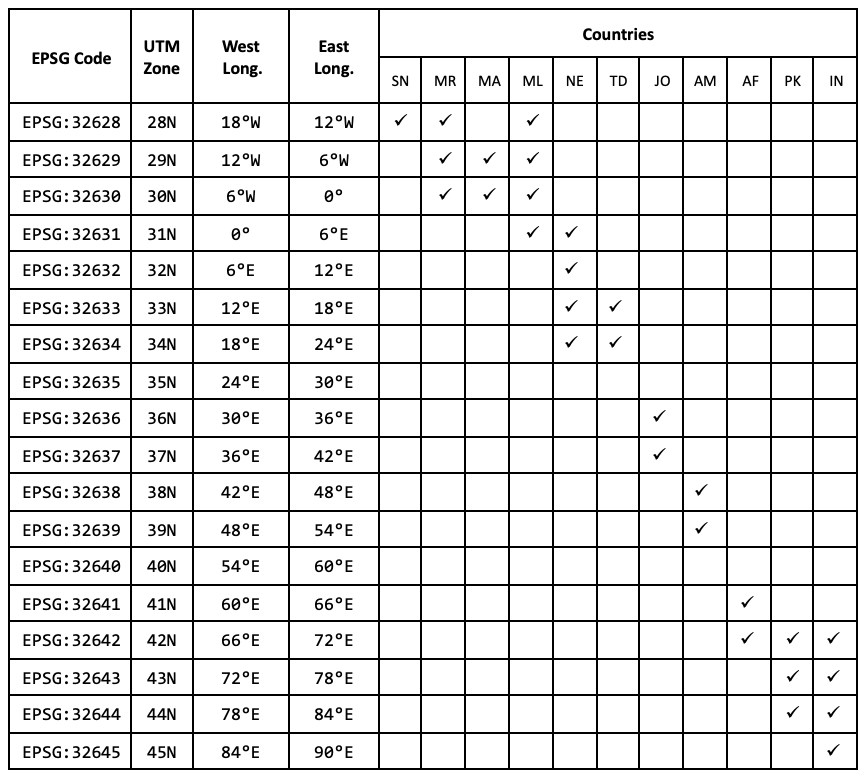


In [1]:
import os
from osgeo import gdal, osr, ogr 
from dataclasses import dataclass

# Import module that contains several convenience functions (e.g., gdal wrappers)
from gist_utils import *

# Adding path to gdal commands for local system
os.environ['PATH'] += ':/Users/billk/miniforge3/envs/py39-pt/bin/' 

## 1 Configurations

The following settings must be specified:
```
shapefile_path: Path to the DHS country shape file that comntains the survey locations
aoi_name:       Country code and UTM zone (e.g., PK_42N)
expected_crs:   Corresponding CRS EPSG code for the UTM Zone (e.g., 'EPSG:32642')
```

In [2]:
# Country level DHS data
#shapefile_path = './DHS/PK_2017-18_DHS_05072024_2158_211908/PKGE71FL/PKGE71FL.shp'
shapefile_path = './DHS/TD_2014-15_DHS_05072024_1511_211908/TDGE71FL/TDGE71FL.shp'
cluster_field  = 'DHSCLUST'
lat_field      = 'LATNUM'
lon_field      = 'LONGNUM'

# Set the aoi name for programmatic file naming below
#aoi_name = 'PK_41N' 
aoi_name = 'TD_34N' 

# The code further below will check that the input rasters (above) match the expected CRS and pixel size
#expected_crs         = 'EPSG:32641'  # This should match the CRS in the input rasters
expected_crs         = 'EPSG:32634'  # This should match the CRS in the input rasters
expected_pixel_size  = (400, 400)    # This should match the pixel size in the input rasters

# Set the resolution for programmatic file naming below
res = expected_pixel_size[0]

# Build a list of the raster  (produced by: prep_geospatial_data.ipynb)
aoi_image_stack_folder = f'./AOI/{aoi_name}/Image_Stack/'

# List all files in the image stack
aoi_image_stack_paths = [os.path.join(aoi_image_stack_folder, file) for file in os.listdir(aoi_image_stack_folder) if file.endswith('.tif')]

# Image tile outputs (folders where image tiles are stored for each data type)
image_tile_folders = []
image_tile_folders.append(f'./AOI/{aoi_name}/Image_Tiles/Nightlights/')
image_tile_folders.append(f'./AOI/{aoi_name}/Image_Tiles/Population/')
image_tile_folders.append(f'./AOI/{aoi_name}/Image_Tiles/Rainfall/')

image_tile_suffixes = []
image_tile_suffixes.append(f'Nightlights_2022_{res}m')
image_tile_suffixes.append(f'Population_2022_{res}m')
image_tile_suffixes.append(f'Rainfall_2023_{res}m')

# VRT filename suffix
vrt_file_suffixes = []
vrt_file_suffixes.append(f'Nightlights_2022_{res}m')
vrt_file_suffixes.append(f'Population_2022_{res}m')
vrt_file_suffixes.append(f'Rainfall_2023_{res}m')

## 2 Extract Cluster IDs and Associated GPS Coordinates

In [3]:
cluster_data = extract_cluster_info(shapefile_path, cluster_field, lat_field, lon_field)

# Print a few records
for idx in range(0,5):
    print(cluster_data[idx])   

(1.0, 9.453506, 18.944837)
(2.0, 13.466001, 22.196232)
(3.0, 15.749017, 18.285138)
(4.0, 12.13549, 15.206105)
(5.0, 9.264128, 16.400491)


## 3 Load AOI Raster Data

In [4]:
# Initialize a list to store the results
results = []

# Loop through each raster path and call the function
for path in aoi_image_stack_paths:
    
    raster, crs_match, pixel_size_match = load_raster(path, expected_crs, expected_pixel_size)
    result = {
        'path': path,
        'raster': raster, 
        'crs_match': crs_match,
        'pixel_size_match': pixel_size_match
    }
    results.append(result)

### Check Image Stack Metadata 

In [5]:
# Check 
# !gdalinfo {aoi_image_stack_paths[0]}

In [6]:
# # Check 
# !gdalinfo {aoi_image_stack_paths[1]}

In [7]:
# # Check 
# !gdalinfo {aoi_image_stack_paths[2]}

## 4 Convert DHS GPS Locations to UTM

In [8]:
all_crs_match = all(result['crs_match'] for result in results)

if all_crs_match:
    utm_coordinates = convert_cluster_coordinates(cluster_data, src_crs='EPSG:4326', dst_crs=expected_crs)
    print(len(utm_coordinates))
    print(utm_coordinates[0])
else:
    print("*** Error: CRS does not match.")

624
(1, 274351.11826877866, 1045656.0743630668)


## 5 Find DHS Points that Fall within the Input Raster Files
The input raster files were previously cropped, projected to the same UTM zone, and resampled to the same pixel size. The cropping was extended in longitide to accomodate cropping near the boundaries. So the raster files intentionally extend beyond the longitude boundaries of the UTM zone. 

When the function below is called to determine which DHS points fall within the boundaries of the raster file, the raster file itself is not used to determine inclusion, but rather the longitude bands for the given UTM zone. 

In [9]:
all_pixel_match = all(result['pixel_size_match'] for result in results)

if all_pixel_match:
    # Collect number of points in each dataset for comparison
    number_of_points_per_dataset = []

    for result in results:
        raster = result['raster']
        points_within_raster = find_points_within_raster_zone(raster, utm_coordinates)
        
        # Store the points within raster into the results dictionary for each raster
        result['points_within_raster'] = points_within_raster
        number_of_points_per_dataset.append(len(points_within_raster))
        print(f"Points w/in bounds: {result['path']}: {len(points_within_raster)}\n")

    # Check if all datasets have the same number of points
    if len(set(number_of_points_per_dataset)) == 1:
        print("All datasets have the same number of points.")
    else:
        print("Warning: Datasets have varying numbers of points. Here are the counts per dataset:", number_of_points_per_dataset)

else:
    print("Pixel size match does not match for one or more rasters.")


epsg_code:  EPSG:32634
Points w/in bounds: ./AOI/TD_34N/Image_Stack/landscan-global-2022_TD_34N_4_resampled_average.tif: 241

epsg_code:  EPSG:32634
Points w/in bounds: ./AOI/TD_34N/Image_Stack/chirps-v2.0.2023_TD_34N_avg_TD_34N_4_resampled_average.tif: 241

epsg_code:  EPSG:32634
Points w/in bounds: ./AOI/TD_34N/Image_Stack/VNL_v22_npp-j01_2022_global_vcmslcfg_median_TD_34N_4_resampled_average.tif: 241

All datasets have the same number of points.


## Debug:  `points_within_raster`

In [10]:
# for idx, item in enumerate(points_within_raster[:100]):
#     x, y = item['point'].coords[0]  # Assuming the point has coords attribute which is a tuple
#     lat, lon = utm_to_latlon(x, y)
#     if lon > 72.0 or lon < 66.0:
#         print(f"Point: POINT ({x:.3f} {y:.3f}) ({lat:.3f} {lon:.3f}) with Cluster ID: {item['cluster_id']}")
#         x,y = latlon_to_utm(lat,lon)
#         print(f"Point: POINT ({x:.3f} {y:.3f})")

In [11]:
# #----------------
# # TEST CASE
# #----------------
# specific_cluster_id = 101  # The cluster ID you are interested in

# # Initialize an empty list to store specific points
# specific_points = []

# # Loop through each point and check the cluster ID
# for item in points_within_raster:
#     if item['cluster_id'] == specific_cluster_id:
#         specific_points.append(item)
#         print(f"Point: {item['point']} with Cluster ID: {item['cluster_id']}")

In [12]:
# # Use a point that was determined above to be within the AOI.
# print(points_within_raster[0])

# first_point = points_within_raster[0]  # Get the first point from the list

# # Now access its x and y coordinates for use with find_nearest_vertex() below.
# x = first_point['point'].x
# y = first_point['point'].y

## Debug: `find_nearest_vertex`
Test find_nearest_vertex() which will be used further below from within crop_raster()

In [13]:
# first_point = specific_points[0]  # Get the first point from the list

# # Now access its x and y coordinates for use with find_nearest_vertex() below.
# x = first_point['point'].x
# y = first_point['point'].y

### Rasterio Version

In [14]:
# nearest_vertex = find_nearest_vertex_rasterio(results[0]['raster'], x, y)
# print("Nearest vertex UTM coordinates:", nearest_vertex)

### GDAL Version

In [15]:
# debug = True
# rasterio_dataset = results[0]['raster']
# if isinstance(rasterio_dataset, rasterio.io.DatasetReader):
#     raster_path = rasterio_dataset.name
# else:
#     raise ValueError("The input must be a rasterio dataset.")

# # Open the raster file using GDAL
# gdal_raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

# nearest_vertex = find_nearest_vertex_gdal(gdal_raster, x, y)
# print("Nearest vertex UTM coordinates:", nearest_vertex)

## 6 Crop Image Tiles from AOI Image Stack
Loop over each data type which is stored in memory as a raster and crop an image tile of the specified size for each of the survey points specified in the `points_within_raster` list. Additionally, build a VRT file which referneces the image tiles for each data type. The VRT facilitates  loading a large number of image tiles in QGIS for visualization purposes.

In [16]:
# Loop over each result and its corresponding image tile path
idx = 0
for result, image_tile_folder, image_tile_suffix in zip(results, image_tile_folders, image_tile_suffixes):
    
    raster = result['raster']
    
    crop_raster_rasterio(raster, points_within_raster, aoi_name, image_tile_suffix, image_tile_folder, tile_size=224, debug=False)

    # Construct the VRT filename
    vrt_file = f"./AOI/{aoi_name}/{aoi_name}_{vrt_file_suffixes[idx]}.vrt"
    
    # Build the VRT using the specified tiles in the folder
    command = f"gdalbuildvrt -vrtnodata -999 {vrt_file} {image_tile_folder}/*.tif"
    subprocess.run(command, shell=True, check=True)
    
    idx += 1 

Crops are saved in ./AOI/TD_34N/Image_Tiles/Nightlights/
0...10...20...30...40...50...60...70...80...90...100 - done.
Crops are saved in ./AOI/TD_34N/Image_Tiles/Population/
0...10...20...30...40...50...60...70...80...90...100 - done.
Crops are saved in ./AOI/TD_34N/Image_Tiles/Rainfall/
0...10...20...30...40...50...60...70...80...90...100 - done.
